Homework №4. Смирнов Николай       
Решить задачу классификации инфаркта по записям PPG.   

ML-решение - на ваше усмотрение + 2 балла.     
Попробовать фильтровать сигнал, чтобы искать качественные высокоуровневые фичи. По фичам построить пороговый классификатор, сравнить его с ML-решением.     
2.1) Попробовать фильтровать сигнал при помощи рекуррентных фильтров. + 1 балл       

2.2) Попробовать фильтровать сигнал при помощи сверточные оконные фильтры (np.convolve или torch.conv). + 1 балл        

2.3) Попробовать фильтровать сигнал при помощи преобразования Фурье. + 1 балл       

Каждым из способов попробовать извлечь фичи, посмотреть точность.          

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import (brier_score_loss, 
                             confusion_matrix)

In [3]:
data = pd.read_csv("PPG_Dataset.csv")
data.head()

,0,1,2,3,4,5,6,7,8,9,...,1991,1992,1993,1994,1995,1996,1997,1998,1999,Label
0,-0.015552,0.016963,0.013575,0.027204,0.068154,0.129259,0.127915,0.345174,0.197811,0.167651,...,-0.426464,-0.346976,-0.132168,-0.252098,-0.241969,-0.134235,-0.091327,-0.081713,-0.057693,MI
1,0.002323,0.002754,0.022539,0.228807,0.107751,0.034439,0.086007,0.155667,0.163327,0.223759,...,-0.169345,-0.356808,-0.338996,-0.292489,-0.152872,-0.156076,-0.103265,-0.041579,-0.044272,MI
2,0.050481,-0.339781,0.265111,0.045092,0.040086,0.087173,0.092814,0.099586,-0.143305,0.164186,...,-0.401426,-0.402333,-0.373426,-0.303710,0.008599,-0.180633,-0.143135,-0.084758,0.060668,MI
3,0.023882,0.016561,0.248547,0.054567,0.128032,0.085954,0.107359,0.207137,0.174547,-0.100118,...,-0.390700,-0.353882,-0.294014,-0.267005,-0.242258,-0.186946,-0.173718,0.101331,0.063555,MI
4,-0.058591,0.171551,0.057262,0.270869,0.138357,0.078509,0.062504,0.104447,0.134795,0.194248,...,-0.391598,-0.334490,-0.326873,-0.249881,-0.210052,-0.194763,-0.415365,0.015432,0.010321,MI


Данные сбалансированы?

In [4]:
num_classes = data['Label'].value_counts()
num_classes

Label
MI        1294
Normal    1282
Name: count, dtype: int64

Да.

Разделение данных

In [5]:
data_train, data_rest = train_test_split(data,
                                         test_size = 0.2,
                                         random_state = 42,
                                         stratify = data['Label'])

data_valid, data_test = train_test_split(data_rest,
                                         test_size = 0.5,
                                         random_state = 42,
                                         stratify = data_rest['Label'])

Посмотрим как выглядит сигнал "больного" и "здорового" человека:

Больной

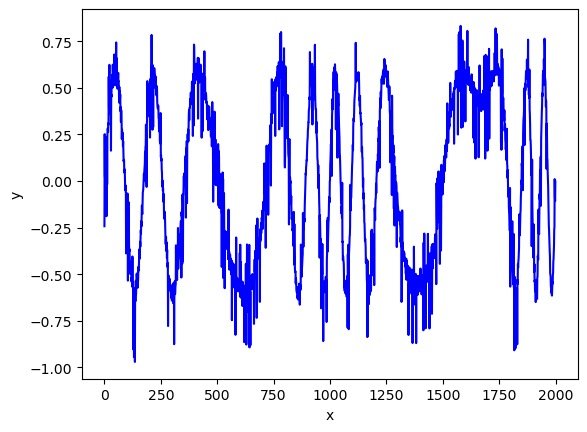

MI


In [6]:
list_x = list(range(2000))
plt.plot(list_x, data_train.drop(columns='Label').iloc[1], color='b')
plt.xlabel('x')
plt.ylabel('y')
plt.show()
print(data_train.iloc[1]['Label']) 

Здоровый

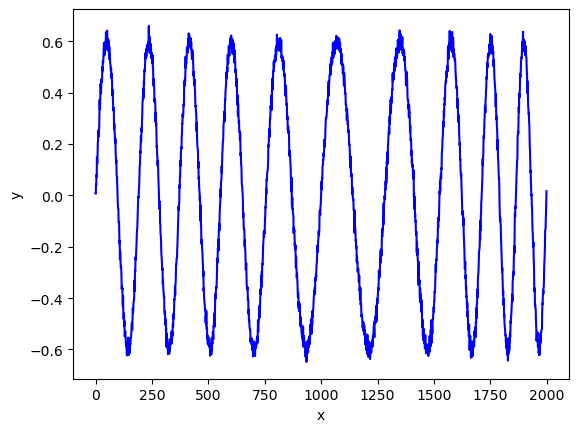

Normal


In [7]:
plt.plot(list_x, data_train.drop(columns='Label').iloc[2], color='b')
plt.xlabel('x')
plt.ylabel('y')
plt.show()
print(data_train.iloc[2]['Label']) 

В качестве фич попробуем взять среднее и стандартоное отклонение:

In [8]:
X_train, y_train = data_train.drop(columns = 'Label'), data_train['Label']
X_valid, y_valid = data_valid.drop(columns = 'Label'), data_valid['Label']
X_test, y_test = data_test.drop(columns = 'Label'), data_test['Label']

In [9]:
def compute_features(df):
    return pd.DataFrame({
        "Mean": df.mean(axis=1),
        "Standard Deviation": df.std(axis=1)
    }, index=df.index)

X_train0 = compute_features(X_train)
X_test0 = compute_features(X_test)
X_valid0 = compute_features(X_valid)

Кодирование меток

In [10]:
binary_encoder = {'Normal':0., 'MI':1.}
y_train = y_train.map(binary_encoder)
y_valid = y_valid.map(binary_encoder)
y_test = y_test.map(binary_encoder)

Модели классификации: Логистическая регрессия, SVM, XGBClassifier

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [12]:
clf1 = LogisticRegression(random_state= 42)
clf2 = SVC(probability = True, random_state = 42)
clf3 = XGBClassifier(random_state = 42)
CLASSIFIERS = [clf1, clf2, clf3]

In [13]:
for i,model in enumerate(CLASSIFIERS):
    name_model = type(model).__name__
    
    model.fit(X_train0, y_train.values)

    y_pred_proba_train = model.predict_proba(X_train0)[:,1]
    y_pred_proba_valid = model.predict_proba(X_valid0)[:,1]
    
    print(f"{name_model}: brier_score_train = {brier_score_loss(y_train, y_pred_proba_train)}, brier_score_valid = {brier_score_loss(y_valid, y_pred_proba_valid)} \n")

LogisticRegression: brier_score_train = 0.2268874034583119, brier_score_valid = 0.22842451087020854 

SVC: brier_score_train = 0.03066238776594513, brier_score_valid = 0.05516218768102387 

XGBClassifier: brier_score_train = 0.01411305429402386, brier_score_valid = 0.05621575631856233 



Выберем модель логистич регрессии:

In [14]:
model = LogisticRegression(random_state = 42, n_jobs = -1)
model.fit(X_train0, y_train.values)

y_pred_proba_test = model.predict_proba(X_test0)[:,1]
y_pred_test = model.predict(X_test0)
print(f"Brier score Test: {brier_score_loss(y_test, y_pred_proba_test):.4f}")
cm = confusion_matrix(y_test, y_pred_test)
print(f"confusion_matrix: \n {cm}")

Brier score Test: 0.2278
confusion_matrix: 
 [[125   3]
 [  9 121]]


Попробуем оставить только среднее:

In [15]:
X_train1 = X_train0.drop(columns = 'Standard Deviation')
X_test1 = X_test0.drop(columns = 'Standard Deviation')

In [16]:
model = LogisticRegression(random_state = 42, n_jobs = -1)
model.fit(X_train1, y_train.values)

y_pred_proba_test = model.predict_proba(X_test1)[:,1]
y_pred_test = model.predict(X_test1)
print(f"Brier score Test: {brier_score_loss(y_test, y_pred_proba_test):.4f}")
cm = confusion_matrix(y_test, y_pred_test)
print(f"confusion_matrix: \n {cm}")

Brier score Test: 0.2412
confusion_matrix: 
 [[125   3]
 [  9 121]]


МГК:

In [17]:
pca = PCA()
pca.fit(X_train)

# Доля объясненной дисперсии для каждого компонента
explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()
print(f"Количество компонентов для 95% дисперсии: {next(i for i, v in enumerate(cumulative_variance) if v >= 0.95) + 1}")

Количество компонентов для 95% дисперсии: 1


In [19]:
pca = PCA(n_components = 1, random_state = 42)
X_train_pca = pca.fit_transform(X_train)
X_valid_pca = pca.transform(X_valid)
X_test_pca = pca.transform(X_test)

In [20]:
model = LogisticRegression(random_state = 42, n_jobs = -1)
model.fit(X_train_pca, y_train.values)

y_pred_proba_test = model.predict_proba(X_test_pca)[:,1]
y_pred_test = model.predict(X_test_pca)
print(f"Brier score Test: {brier_score_loss(y_test, y_pred_proba_test):.4f}")
cm = confusion_matrix(y_test, y_pred_test)
print(f"confusion_matrix: \n {cm}")

Brier score Test: 0.0443
confusion_matrix: 
 [[125   3]
 [  9 121]]


Фильтрация с помощью Фурье:

In [21]:
columns = [f'freq_{i}' for i in range(X_train.shape[1])]
X_train_s = pd.DataFrame(np.fft.fft(X_train.values, axis=1), columns=columns)
X_test_s = pd.DataFrame(np.fft.fft(X_test.values, axis=1), columns=columns)
X_valid_s = pd.DataFrame(np.fft.fft(X_valid.values, axis=1), columns=columns)
X_train_s.head()

,freq_0,freq_1,freq_2,freq_3,freq_4,freq_5,freq_6,freq_7,freq_8,freq_9,...,freq_1990,freq_1991,freq_1992,freq_1993,freq_1994,freq_1995,freq_1996,freq_1997,freq_1998,freq_1999
0,6.798897+ 0.000000j,6.915512- 0.441001j,6.968872+ 0.879284j,5.330583- 2.843062j,18.566690- 1.100567j,-15.161348+ 13.516943j,55.617615-74.232416j,16.355686+171.928458j,-86.313162-254.367694j,192.577587+127.508811j,...,148.555658+ 62.823436j,192.577587-127.508811j,-86.313162+254.367694j,16.355686-171.928458j,55.617615+74.232416j,-15.161348- 13.516943j,18.566690+ 1.100567j,5.330583+ 2.843062j,6.968872- 0.879284j,6.915512+ 0.441001j
1,29.940648+ 0.000000j,90.739738+70.360343j,21.961000+79.728244j,-186.962099+ 2.740211j,-29.302389-59.165179j,256.074966- 81.446859j,-14.859301-33.902509j,-131.793949+ 61.802375j,161.408545+ 49.614186j,60.961288+ 22.249450j,...,31.903137+ 36.948760j,60.961288- 22.249450j,161.408545- 49.614186j,-131.793949- 61.802375j,-14.859301+33.902509j,256.074966+ 81.446859j,-29.302389+59.165179j,-186.962099- 2.740211j,21.961000-79.728244j,90.739738-70.360343j
2,6.605652+ 0.000000j,7.580042- 1.239736j,8.104200- 0.283308j,5.793167- 1.269113j,18.533556- 1.345590j,-15.060534+ 13.142967j,54.209171-73.745631j,16.102935+171.259886j,-87.005711-254.093002j,194.327961+128.152114j,...,148.856569+ 61.895197j,194.327961-128.152114j,-87.005711+254.093002j,16.102935-171.259886j,54.209171+73.745631j,-15.060534- 13.142967j,18.533556+ 1.345590j,5.793167+ 1.269113j,8.104200+ 0.283308j,7.580042+ 1.239736j
3,24.225744+ 0.000000j,91.536781+71.743830j,25.286723+69.161680j,-190.174018+ 3.682766j,-33.846389-66.753939j,254.152393- 82.452521j,-5.533861-34.508710j,-135.222174+ 61.661620j,160.400020+ 53.935364j,60.254246+ 17.750039j,...,32.469435+ 34.481666j,60.254246- 17.750039j,160.400020- 53.935364j,-135.222174- 61.661620j,-5.533861+34.508710j,254.152393+ 82.452521j,-33.846389+66.753939j,-190.174018- 3.682766j,25.286723-69.161680j,91.536781-71.743830j
4,31.584435+ 0.000000j,94.132991+66.414470j,20.949213+74.212658j,-188.773986- 0.050160j,-34.768249-60.732330j,256.895797- 77.964826j,-11.086751-39.085854j,-133.867732+ 61.363999j,157.722355+ 42.734056j,59.069499+ 26.453879j,...,31.107926+ 35.774578j,59.069499- 26.453879j,157.722355- 42.734056j,-133.867732- 61.363999j,-11.086751+39.085854j,256.895797+ 77.964826j,-34.768249+60.732330j,-188.773986+ 0.050160j,20.949213-74.212658j,94.132991-66.414470j


Пусть длительность всех сигналов - 2 секунды, тогда отсчеты по времени представлены с шагом 2/2000 = 0.001c, а частота дискретизации 100ГЦ. Посмотрим на сигнал в частотном пространстве для "больного" и "здорового":

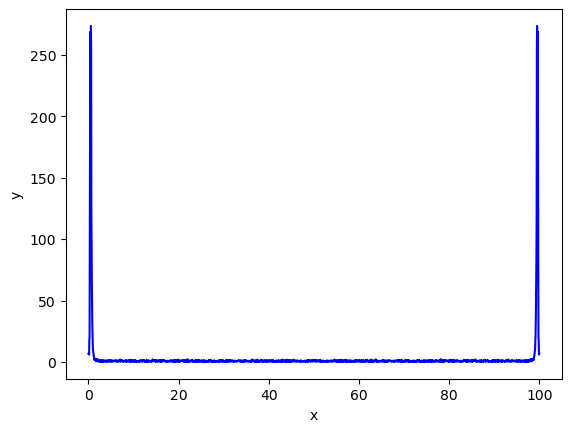

0.0


In [22]:
samplimg_rate = 100
frequencies = np.linspace(0, samplimg_rate, len(X_train_s.iloc[1]))
plt.plot(frequencies, np.abs(X_train_s.iloc[0]), color='b')
plt.xlabel('x')
plt.ylabel('y')
plt.show()
print(y_train.iloc[0]) 

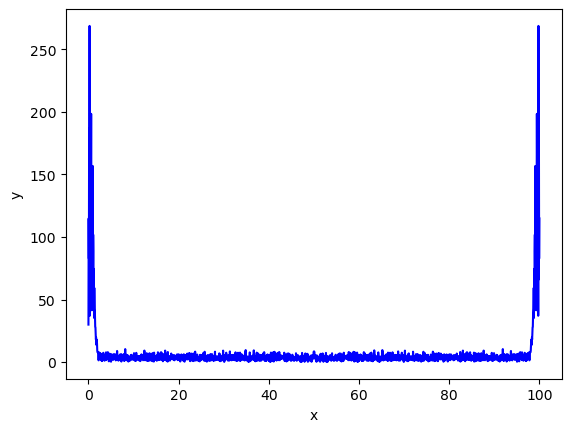

1.0


In [23]:
samplimg_rate = 100
frequencies = np.linspace(0, samplimg_rate, len(X_train_s.iloc[1]))
plt.plot(frequencies, np.abs(X_train_s.iloc[1]), color='b')
plt.xlabel('x')
plt.ylabel('y')
plt.show()
print(y_train.iloc[1]) 

В сигнале "больного" присутствует гауссов шум, отфильтруем его по порогу:

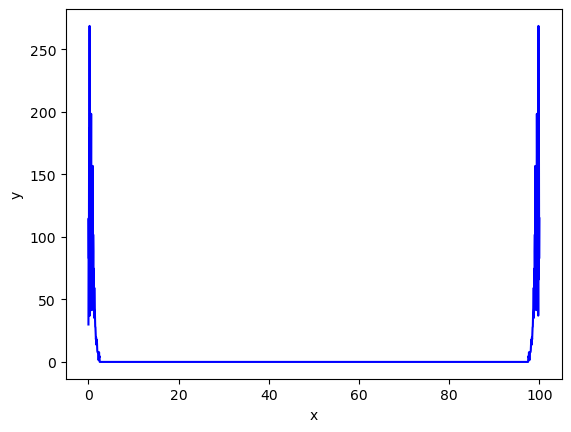

1.0


In [24]:
X_train_filtred_s = X_train_s.copy()
X_train_filtred_s.iloc[:,50:1950] = 0
X_test_filtred_s = X_test_s.copy()
X_test_filtred_s.iloc[:,50:1950] = 0
X_valid_filtred_s = X_valid_s.copy()
X_valid_filtred_s.iloc[:,50:1950] = 0

plt.plot(frequencies, np.abs(X_train_filtred_s.iloc[1]), color='b')
plt.xlabel('x')
plt.ylabel('y')
plt.show()
print(y_train.iloc[1]) 

Применив обратное Фурье получим исходный сигнал и посмотрим на один из них до (красный) и после фильтра (синий):

In [25]:
X_train_filtred = pd.DataFrame(np.fft.ifft(X_train_filtred_s.values, axis=1).real, columns=X_train.columns)
X_test_filtred = pd.DataFrame(np.fft.ifft(X_test_filtred_s.values, axis=1).real, columns=X_test.columns)
X_valid_filtred = pd.DataFrame(np.fft.ifft(X_valid_filtred_s.values, axis=1).real, columns=X_valid.columns)

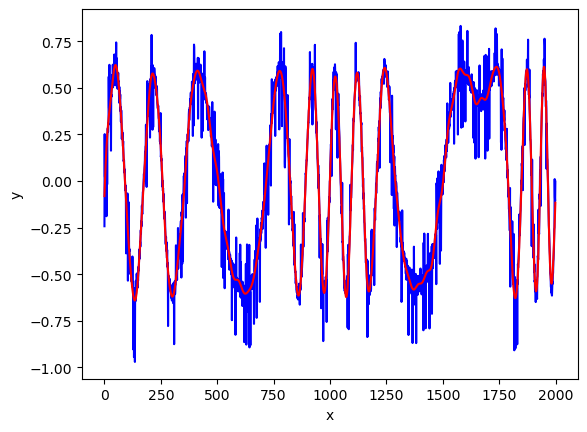

1.0


In [26]:
plt.plot(list_x, data_train.drop(columns='Label').iloc[1], color='b')
plt.plot(list_x, X_train_filtred.iloc[1], color='r')
plt.xlabel('x')
plt.ylabel('y')
plt.show()
print(y_train.iloc[1]) 

Рекуррентный фильтр (экспотенциальное сглаживание):

In [27]:
def exponential_smoothing(df, alpha=0.1):
    df_filtered = df.copy().to_numpy()
    for k in range(1, df.shape[1]):
        df_filtered[:, k] = alpha * df.to_numpy()[:, k] + (1 - alpha) * df_filtered[:, k - 1]
    return pd.DataFrame(df_filtered, index=df.index, columns=df.columns)

In [28]:
X_train_filtred_r = exponential_smoothing(X_train, alpha=0.05)
X_test_filtred_r = exponential_smoothing(X_test, alpha=0.05)

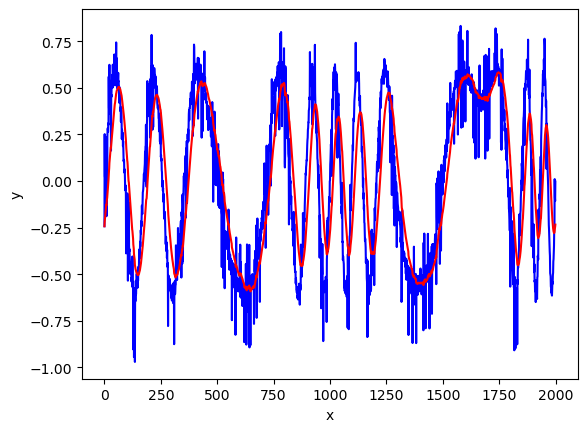

1.0


In [29]:
plt.plot(list_x, data_train.drop(columns='Label').iloc[1], color='b')
plt.plot(list_x, X_train_filtred_r.iloc[1], color='r')
plt.xlabel('x')
plt.ylabel('y')
plt.show()
print(y_train.iloc[1]) 

Сверточный фильтр (Гауссов фильтр):

In [30]:
from scipy.ndimage import gaussian_filter1d

def gaussian_filter(df, sigma=2):
    return pd.DataFrame([gaussian_filter1d(row, sigma=sigma) for row in df.values], 
                        index=df.index, columns=df.columns)

In [31]:
X_train_filtred_c = gaussian_filter(X_train, sigma = 6)
X_test_filtred_c = gaussian_filter(X_test, sigma = 6)

In [32]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
1160,-0.008032,0.021292,0.053120,0.065912,0.071770,0.096610,0.118202,0.099252,0.116811,0.172527,...,-0.262634,-0.262104,-0.220329,-0.190635,-0.167819,-0.068871,-0.092333,-0.068171,-0.038926,0.002786
2346,-0.242611,0.251845,0.026423,0.013133,0.124391,0.124492,0.068360,0.136010,0.074072,-0.188663,...,-0.431950,-0.418345,-0.375153,-0.347229,-0.257891,-0.248911,0.010420,-0.086750,-0.107466,-0.002788
157,0.008460,0.006331,0.044934,0.039727,0.080151,0.072836,0.148628,0.126976,0.124536,0.167607,...,-0.254468,-0.225767,-0.206676,-0.136734,-0.132165,-0.131290,-0.087492,-0.067139,-0.032708,0.016594
1083,-0.022204,0.222189,-0.293633,0.031798,-0.255405,0.085403,0.093095,0.115955,0.139692,0.264153,...,-0.431463,-0.462380,-0.428592,-0.298523,-0.272757,-0.187898,-0.187445,-0.137179,-0.070585,-0.034503
1387,0.203423,-0.258873,0.032535,0.067268,0.107893,0.110444,0.108151,0.153311,0.141928,-0.121713,...,-0.421382,-0.425059,-0.361491,-0.369598,-0.314472,-0.252115,-0.152769,-0.151601,0.018499,0.035049


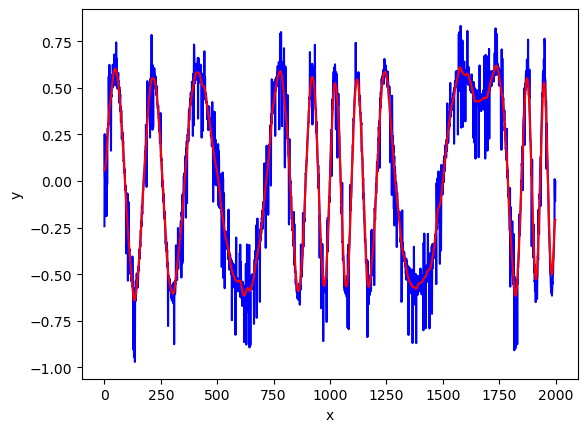

1.0


In [33]:
plt.plot(list_x, data_train.drop(columns='Label').iloc[1], color='b')
plt.plot(list_x, X_train_filtred_c.iloc[1], color='r')
plt.xlabel('x')
plt.ylabel('y')
plt.show()
print(y_train.iloc[1]) 

In [34]:
X_train_filtred0 = compute_features(X_train_filtred)
X_train_filtred_r0 = compute_features(X_train_filtred_r)
X_train_filtred_c0 = compute_features(X_train_filtred_c)
X_test_filtred0 = compute_features(X_test_filtred)
X_test_filtred_r0 = compute_features(X_test_filtred_r)
X_test_filtred_c0 = compute_features(X_test_filtred_c)

Пороговый классификатор по среднему для каждого из отфильтрованных сигналов:

In [35]:
def compute_threshold(df0, name):
    df = df0.copy()
    df["Label"] = y_train
    mean_label_1 = df[df["Label"] == 1]["Mean"].mean()
    mean_label_0 = df[df["Label"] == 0]["Mean"].mean()
    threshold = (mean_label_0 + mean_label_1) / 2
    
    print(f"{name}:")
    print(f"  Порог: {threshold:.5f}")
    print("-" * 40)


compute_threshold(X_train_filtred0, "Fourier filter")
compute_threshold(X_train_filtred_r0, "recurrent filter")
compute_threshold(X_train_filtred_c0, "convolutional filter")

Fourier filter:
  Порог: 0.00967
----------------------------------------
recurrent filter:
  Порог: 0.01216
----------------------------------------
convolutional filter:
  Порог: 0.00963
----------------------------------------


In [36]:
def compute_and_print_cm(df, y_test, threshold):
    y_pred = (df["Mean"] >= threshold).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    print(f"confusion_matrix: \n {cm}\n")

threshold = 0.0098754
print("Results for X_test_filtred0:")
compute_and_print_cm(X_test_filtred0, y_test, 0.00987)
print("Results for X_test_filtred_r0:")
compute_and_print_cm(X_test_filtred_r0, y_test, 0.01216)
print("Results for X_test_filtred_s0:")
compute_and_print_cm(X_test_filtred_c0, y_test, 0.00963)

Results for X_test_filtred0:
confusion_matrix: 
 [[125   3]
 [  9 121]]

Results for X_test_filtred_r0:
confusion_matrix: 
 [[125   3]
 [  9 121]]

Results for X_test_filtred_s0:
confusion_matrix: 
 [[125   3]
 [  9 121]]



Понятно, что фильтрация никак не улучшит нашу модель с точки зрения фич Mean и Standard Deviation:

In [37]:
def evaluate_model_log_reg(df_train, df_test):
    model = LogisticRegression(random_state = 42, n_jobs = -1)
    model.fit(df_train, y_train.values)
    y_pred_proba_test = model.predict_proba(df_test)[:, 1]
    y_pred_test = model.predict(df_test)
    brier_score = brier_score_loss(y_test, y_pred_proba_test)
    cm = confusion_matrix(y_test, y_pred_test)
    
    return brier_score, cm

In [38]:
signals = [("X_test_filtred0", X_train_filtred0, X_test_filtred0), 
            ("X_test_filtred_r0", X_train_filtred_r0,X_test_filtred_r0), 
            ("X_test_filtred_s0", X_train_filtred_c0,X_test_filtred_c0)]

for name, df_train, df_test in signals:
    brier_score, cm = evaluate_model_log_reg(df_train, df_test)
    print(f"Results for {name}:")
    print(f"Brier score Test: {brier_score:.4f}")
    print(f"confusion_matrix: \n{cm}\n")

Results for X_test_filtred0:
Brier score Test: 0.2371
confusion_matrix: 
[[125   3]
 [  9 121]]

Results for X_test_filtred_r0:
Brier score Test: 0.2414
confusion_matrix: 
[[125   3]
 [  9 121]]

Results for X_test_filtred_s0:
Brier score Test: 0.2400
confusion_matrix: 
[[125   3]
 [  9 121]]



В качестве фичи можно попробовать например Интервалы между пиками (HRV — вариабельность сердечного ритма):

In [40]:
import pandas as pd
import neurokit2 as nk


def process_ppg(row):
    ppg_signal = row.values[:]
    signals, _ = nk.ppg_process(ppg_signal, sampling_rate=100)
    hrv_features = nk.hrv_time(signals, sampling_rate=100)
    selected_features = hrv_features[["HRV_RMSSD", "HRV_SDSD", "HRV_IQRNN"]]
    
    return selected_features.iloc[0]

X_train_filtred_hrv = X_train_filtred.apply(process_ppg, axis=1)
X_test_filtred_hrv = X_test_filtred.apply(process_ppg, axis=1)
X_train_filtred_hrv = X_train_filtred_hrv.fillna(0)
X_test_filtred_hrv = X_test_filtred_hrv.fillna(0)

X_train_filtred_r_hrv = X_train_filtred_r.apply(process_ppg, axis=1)
X_test_filtred_r_hrv = X_test_filtred_r.apply(process_ppg, axis=1)
X_train_filtred_r_hrv = X_train_filtred_r_hrv.fillna(0)
X_test_filtred_r_hrv = X_test_filtred_r_hrv.fillna(0)

X_train_filtred_c_hrv = X_train_filtred_c.apply(process_ppg, axis=1)
X_test_filtred_c_hrv = X_test_filtred_c.apply(process_ppg, axis=1)
X_train_filtred_c_hrv = X_train_filtred_c_hrv.fillna(0)
X_test_filtred_c_hrv = X_test_filtred_c_hrv.fillna(0)

In [41]:
signals = [("X_test_filtred0", X_train_filtred_hrv, X_test_filtred_hrv), 
            ("X_test_filtred_r0", X_train_filtred_r_hrv,X_test_filtred_r_hrv), 
            ("X_test_filtred_s0", X_train_filtred_c_hrv,X_test_filtred_c_hrv)]

for name, df_train, df_test in signals:
    brier_score, cm = evaluate_model_log_reg(df_train, df_test)
    print(f"Results for {name}:")
    print(f"Brier score Test: {brier_score:.4f}")
    print(f"confusion_matrix: \n{cm}\n")

Results for X_test_filtred0:
Brier score Test: 0.0450
confusion_matrix: 
[[125   3]
 [  9 121]]

Results for X_test_filtred_r0:
Brier score Test: 0.0448
confusion_matrix: 
[[125   3]
 [  9 121]]

Results for X_test_filtred_s0:
Brier score Test: 0.0443
confusion_matrix: 
[[125   3]
 [  9 121]]



Получаем все те же метрики accuracy, precision, recall. В нашем случае скорее всего фильтрация никак не помогает улучшить метрики. Для предсказания класса достаточно порогового классификатора просто по среднему.